This is a small example showing how to use [fastai](https://www.fast.ai) to train on the original [MNIST](http://yann.lecun.com/exdb/mnist) dataset. This notebook aims to serve two purposes, first to demonstrate how to pass data in custom numpy data and second to show how quick it is to write code to train the data.

The MNIST dataset contains 70,000 handwritten digits from 0 to 9. 60,000 for training and 10,000 for testing. Each digit is a tiny grayscale 28x28 image.

For training I use a pre-trained resnet model and did transfer learning.

This Jupyter notebook can be downloaded here https://github.com/nghiaho12/fastai_projects/blob/main/mnist.ipynb 

# Table of Contents
1. [Load the MNIST data](#load)
2. [Visualize some the data](#viz)
3. [Custom Transform class](#transform)
4. [Setup Dataloaders](#dataloaders)
5. [Train the model](#train)
6. [Evaluate the model on the test set](#test_eval)
7. [Visualize misclassification](#viz_miss)
8. [Summary](#conclusion)

# 1. Load the MNIST data <a name="load"></a>
This will download the MNIST data if you don't have it already.

In [1]:
from fastai.vision.all import *
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import sys
import gzip

plt.style.use('dark_background')

print("torch.cuda.device_count():", torch.cuda.device_count())
print("torch.cuda.current_device():", torch.cuda.current_device())
print("torch.cuda.get_device_name(0):", torch.cuda.get_device_name(0))
if torch.cuda.is_available() == False:
    raise ValueError("No CUDA device found!")

def read_mnist_image(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_images = int.from_bytes(f.read(4), byteorder='big')
        image_height = int.from_bytes(f.read(4), byteorder='big')
        image_width = int.from_bytes(f.read(4), byteorder='big')

        buf = f.read(image_width * image_height * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, image_height, image_width)
        #data = data.astype(dtype=np.float32) / 255.0 # normalize to [0,1]
        
        return data
    
def read_mnist_label(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        buf = f.read(num_labels)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)

        return data
    
# download dataset if it doesn't exist    
files = ['train-images-idx3-ubyte.gz', 
         'train-labels-idx1-ubyte.gz', 
         't10k-images-idx3-ubyte.gz', 
         't10k-labels-idx1-ubyte.gz']

for f in files:
    if not os.path.exists(f):        
        url = 'http://yann.lecun.com/exdb/mnist/' + f
        print(url)
        download_url(url, f)
        
train_image = read_mnist_image('train-images-idx3-ubyte.gz')
train_label = read_mnist_label('train-labels-idx1-ubyte.gz')
test_image = read_mnist_image('t10k-images-idx3-ubyte.gz')
test_label = read_mnist_label('t10k-labels-idx1-ubyte.gz')

print("train_image:", train_image.shape)
print("train_label:", train_label.shape)
print("test_image:", test_image.shape)
print("test_label:", test_label.shape)

torch.cuda.device_count(): 1
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): GeForce MX250
train_image: (60000, 28, 28)
train_label: (60000,)
test_image: (10000, 28, 28)
test_label: (10000,)


# 2. Visualize some of the data <a name="viz">
This is a sanity check to make sure we loaded the images correctly.

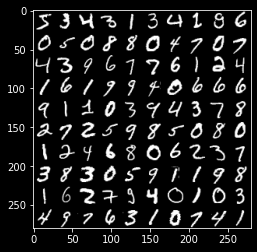

In [2]:
nrows = 10
ncols = 10

_, h, w = train_image.shape
canvas = Image.new('L', (ncols*w, nrows*h))

idx = 0
for i in range(nrows):
    for j in range(ncols):
        image = Image.fromarray(train_image[idx])
        canvas.paste(image, (i*h, j*w))
        idx += 1
        
imshow(np.asarray(canvas), cmap='gray');

# 3. Custom Transform class <a name="transform">
Based on information from [https://docs.fast.ai/tutorial.siamese.html](https://docs.fast.ai/tutorial.siamese.html). This class handles our custom data. I also implemented show_batch in case I want to visualize the batch.

In [3]:
class NumpyImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img, label = self
        return show_image(img, title=label, ctx=ctx, **kwargs)        

class NumpyTransform(Transform):
    def __init__(self, data, label):
        self.img = data
        self.label = label
    
    def encodes(self, i):
        num, h, w = self.img.shape
        
        # The CNN network expects an RGB image
        rgb = np.zeros((3, h, w))
        rgb[0, :, :] = self.img[i]
        rgb[1, :, :] = self.img[i]
        rgb[2, :, :] = self.img[i]
        
        rgb = rgb.astype(np.float32) / 255.0
        
        # Without TensorCategory the CNN will think you're doing regression instead (I think)!
        return NumpyImage(torch.tensor(rgb), TensorCategory(self.label[i]))

# This isn't required, but nice to have!
# This will allow you to call dls.show_batch() later on
if True:
    @typedispatch
    def show_batch(
        x: NumpyImage, y, samples, 
        ctxs = None, max_n = 9, 
        nrows = None, ncols = 3, 
        figsize = None, **kwargs):

        if figsize is None: 
            figsize = (10, 10)

        if ctxs is None: 
            ctxs = get_grid(
                min(x[0].shape[0], max_n), 
                nrows = None, ncols = ncols, 
                figsize = figsize)

        for i, ctx in enumerate(ctxs): 
            NumpyImage(x[0][i], x[1][i].item()).show(ctx=ctx)

# 4. Setup dataloaders <a name="dataloaders">
Split the data into a training and validation set and initialize the dataloader.

In [4]:
num_images = train_image.shape[0]
trn, val = RandomSplitter()(range(num_images)) # use default train/validation split

train_tl = TfmdLists(trn, NumpyTransform(train_image, train_label))
valid_tl = TfmdLists(val, NumpyTransform(train_image, train_label))

dls = DataLoaders.from_dsets(train_tl, valid_tl, num_workers=0) # num_workers=0 fixes runtime error
dls = dls.cuda() # ugh why isn't this the default!
#dls.show_batch()

# 5. Train model <a name="train">
Here I do transfer learning using a pre-trained resnet18 model.

In [5]:
learn = cnn_learner(dls, models.resnet18, n_out=10, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fine_tune(5)
learn.save("mnist_model")

epoch,train_loss,valid_loss,accuracy,time
0,0.750449,0.516361,0.835833,00:39


epoch,train_loss,valid_loss,accuracy,time
0,0.156966,0.089965,0.971500,01:04
1,0.091181,0.043143,0.986500,01:04
2,0.050804,0.032924,0.990500,01:05
3,0.021729,0.026623,0.992417,01:05
4,0.012898,0.025683,0.992500,01:05


Path('models/mnist_model.pth')

Accuracy is 99.25% after 5 iterations, pretty good!

# 6. Evaluate model on test set <a name="eval_test">
Load the saved model and perform inference on the test set. I've duplicated some code to demonstrate how to load the model at a later time. 

In [6]:
learn = cnn_learner(dls, models.resnet18, n_out=10, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn = learn.load("mnist_model")

test_tl = TfmdLists(range(test_image.shape[0]), NumpyTransform(test_image, test_label))
dl = learn.dls.test_dl(test_tl)
pred = learn.get_preds(dl=dl)
accuracy(pred[0], torch.from_numpy(test_label)).item()

0.991599977016449

Good accuracy on the test set as well!

# 7. Visualize misclassification <a name="viz_miss">
Let's visualize the misclassified images. The text on top of each image shows the results as [predicted|ground truth]. Some of these mistakes are tricky even for a human!

misclassfication: 84


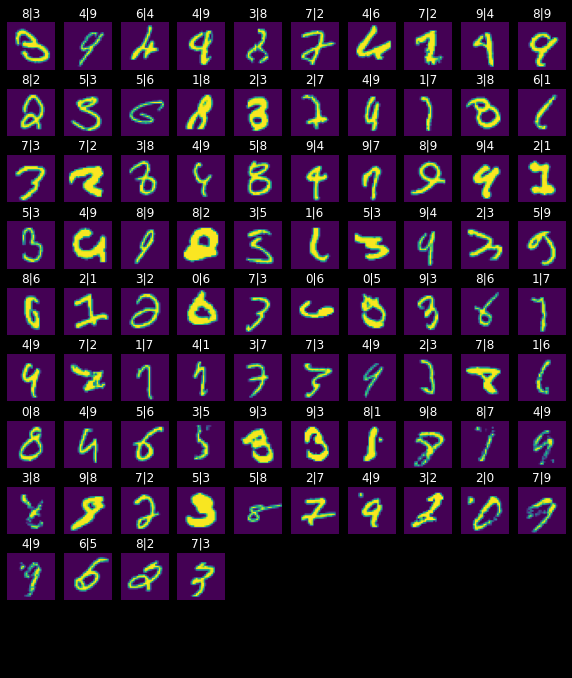

In [12]:
pred_label = pred[0].argmax(dim=1) 
wrong_idx = torch.nonzero(pred_label != torch.from_numpy(test_label))
print(f"misclassfication: {wrong_idx.shape[0]}")

# show up to 100 results
ctxs = get_grid(min(wrong_idx.shape[0], 100), nrows=10, ncols=10, figsize=(10,12))

for i, ctx in enumerate(ctxs): 
    idx = wrong_idx[i]
    NumpyImage(test_image[idx], f"{pred_label[idx].item()}|{test_label[idx]}").show(ctx=ctx)

# 8. Summary <a name="summary"></a>
Getting the numpy array into fastai requires some custom code, which I found a bit painful to get working right initially, but that's probably due to my limited familiarity with the library. I've only started learning fastai and this is my first project using it. 

An annoying gotcha I came across was forgetting to call dls = dls.cuda(). Without this Pytorch will use the CPU instead. I didn't suspect anything until I ran the notebook on a more powerful GPU and noticed I was not getting any speedup!

MNIST is an old school dataset that is really easy to get near perfect results on without trying too hard. In this case I took a an existing pre-trained resnet18 model and performed some fine tuning. No further tricks were necessary. It also shows the power of transfer learning.